In [1]:
import time
import os
import cv2
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from tensorflow.keras.preprocessing.image import img_to_array,load_img

# optional
# from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt


# Enable GPU dynamic memory allocation (do not use this for colab)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


- Loading the model

In [2]:
PATH_TO_SAVED_MODEL = "exported-models/my_ssd_mobilenet_v2_320x320/saved_model"
PATH_TO_LABELS = "annotations/label_map.pbtxt"

print('Loading Model...')
start_time = time.time()
loaded_model = tf.saved_model.load(PATH_TO_SAVED_MODEL)

# Loading the pbtxt
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

print('Done! Took {} seconds'.format(time.time() - start_time))

Loading Model...
Done! Took 37.456233501434326 seconds


- Checking the signature of the models i.e output shapes, datatypes and inputs

In [5]:
print(loaded_model.signatures['serving_default'].inputs[0])
print(loaded_model.signatures['serving_default'].output_dtypes)
print(loaded_model.signatures['serving_default'].output_shapes)
# Here the input is expected in uint8 dtype, but our is in float32. So we need to convert that below.

Tensor("input_tensor:0", shape=(1, None, None, 3), dtype=uint8)
{'detection_anchor_indices': tf.float32, 'detection_boxes': tf.float32, 'detection_classes': tf.float32, 'detection_multiclass_scores': tf.float32, 'detection_scores': tf.float32, 'num_detections': tf.float32, 'raw_detection_boxes': tf.float32, 'raw_detection_scores': tf.float32}
{'detection_anchor_indices': TensorShape([1, 100]), 'detection_boxes': TensorShape([1, 100, 4]), 'detection_classes': TensorShape([1, 100]), 'detection_multiclass_scores': TensorShape([1, 100, 3]), 'detection_scores': TensorShape([1, 100]), 'num_detections': TensorShape([1]), 'raw_detection_boxes': TensorShape([1, 2034, 4]), 'raw_detection_scores': TensorShape([1, 2034, 3])}


- ### Making group predicition

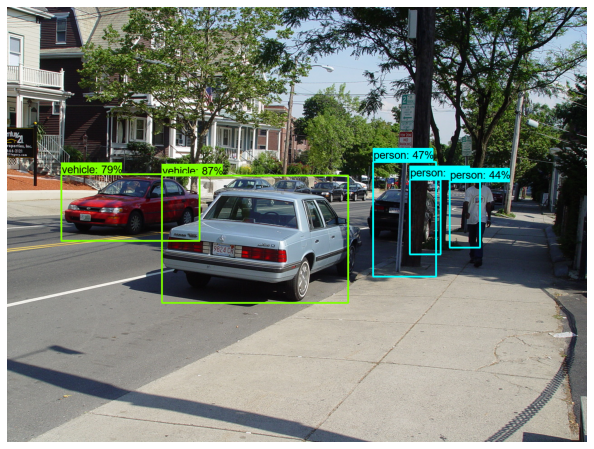

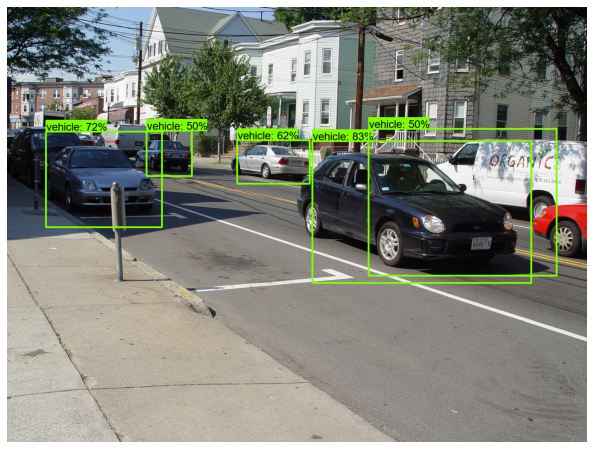

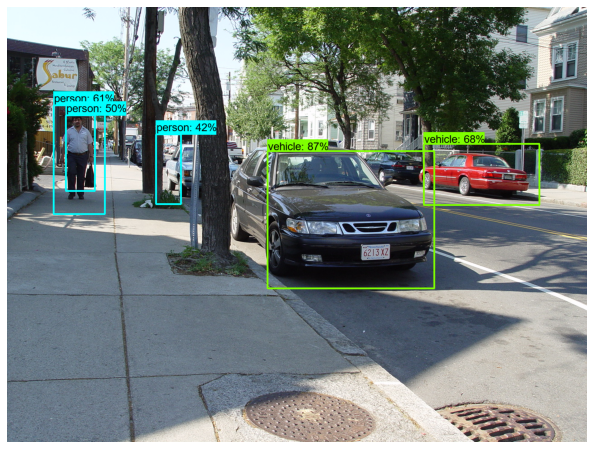

In [41]:
NO_OF_PREDICTIONS = 5
TEST_IMAGE_PATH = 'images/test'
TEST_IMAGE_EXTENSION = '.jpg'


input_images = [img for img in os.listdir(TEST_IMAGE_PATH) if img.lower().endswith(TEST_IMAGE_EXTENSION)][:NO_OF_PREDICTIONS]
for img in input_images:
  img_path = os.path.join(TEST_IMAGE_PATH,img)
  # img_path = TEST_IMAGE_PATH+'/'+str(img)
  test_image_o = cv2.imread(img_path)
  test_image_rgb = cv2.cvtColor(test_image_o, cv2.COLOR_BGR2RGB)

  test_image_array = np.expand_dims(test_image_rgb,axis=0)

  test_image_tensor = tf.convert_to_tensor(test_image_array)
  test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.

  prediction = loaded_model(test_image_tensor)
  # prediction preprocessing
  num_bboxes = int(prediction.pop('num_detections'))
  prediction = {key: value[0, :num_bboxes].numpy()
                 for key, value in prediction.items()}
  prediction['num_detections'] = num_bboxes
  # detection_classes should be ints.
  prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)

  image_with_detections = test_image_rgb.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_with_detections,
        prediction['detection_boxes'],
        prediction['detection_classes'],
        prediction['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=0.4,
        agnostic_mode=False)

  # For colab
#   cv2_imshow(image_with_detections) 

  # For local machine
  # from PIL import Image
  # import matplotlib.pyplot as plt
  # %matplotlib inline
  # Image.fromarray(image_with_detections, 'RGB')
  
  fig = plt.figure(figsize=(14,8))
  plt.axis('off')
  plt.imshow(image_with_detections)
  
  plt.show()
  

- Single prediction

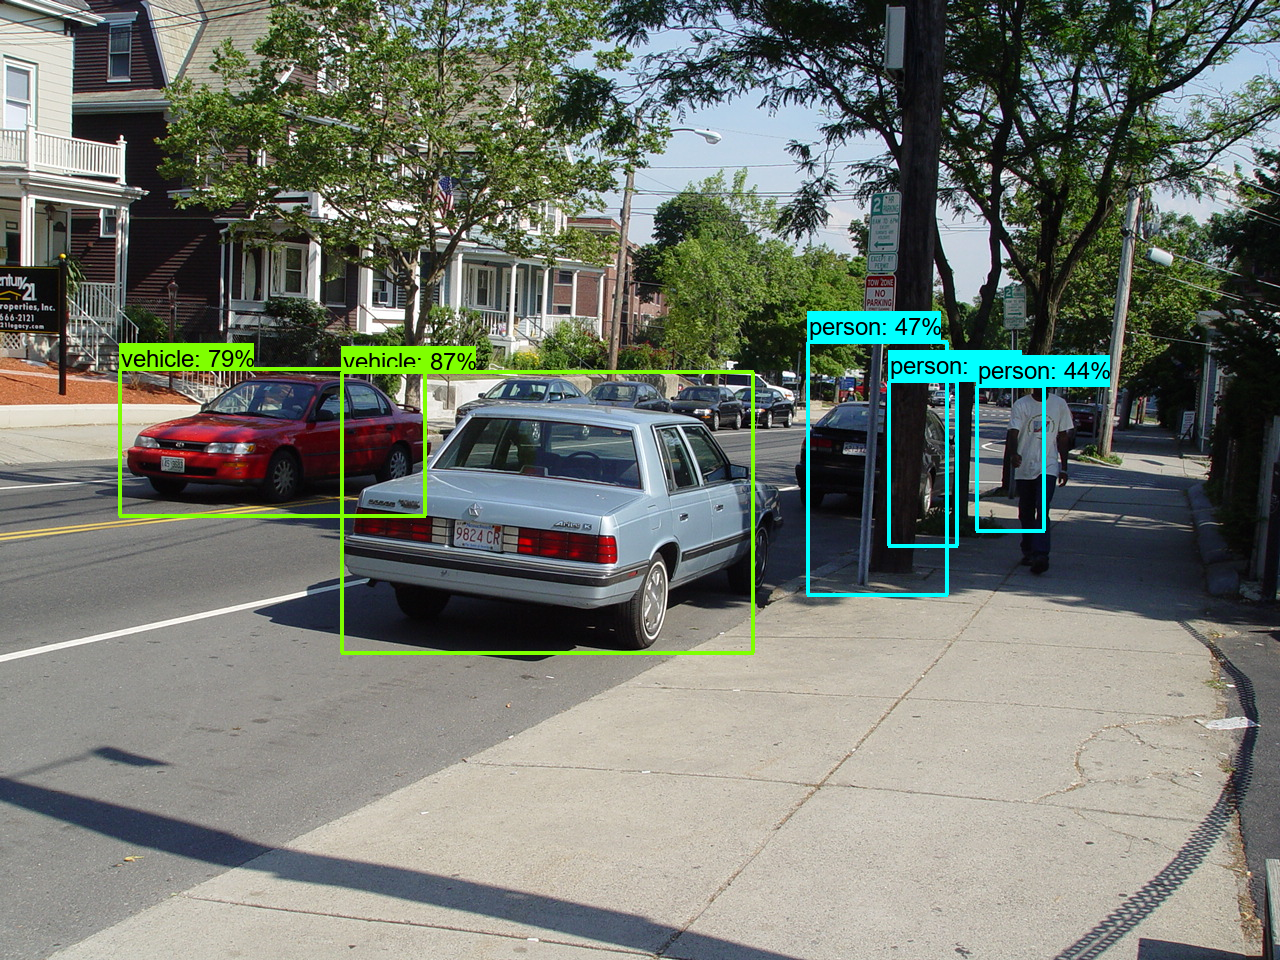

In [ ]:
# Image to array
# test_image_o = load_img('images/test/SSDB00201.JPG')
# test_image_array = img_to_array(test_image_o) 
test_image_o = cv2.imread('images/test/SSDB00201.JPG')
test_image_rgb = cv2.cvtColor(test_image_o, cv2.COLOR_BGR2RGB)
test_image_array_ex = np.expand_dims(test_image_rgb, axis=0)

# The model expects a batch of images, so add an axis
# test_image_array_ex = np.expand_dims(test_image_array,axis=0)

# Image to Tensor
test_image_tensor = tf.convert_to_tensor(test_image_array_ex)
# test_image_tensor = test_image_tensor[tf.newaxis,...]
test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.

# Predictions
prediction = loaded_model(test_image_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.\

num_bboxes = int(prediction.pop('num_detections'))
prediction = {key: value[0, :num_bboxes].numpy()
               for key, value in prediction.items()}
prediction['num_detections'] = num_bboxes

# detection_classes should be ints.
prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)

image_with_detections = test_image_rgb.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      prediction['detection_boxes'],
      prediction['detection_classes'],
      prediction['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=5,
      min_score_thresh=0.4,
      agnostic_mode=False)

# For colab
# from google.colab.patches import cv2_imshow
# cv2_imshow(image_with_detections) 

Image.fromarray(image_with_detections, 'RGB')


- ### Video prediction

In [6]:
def show_inference(model,frame):
    test_image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # OpenCV reads images in BGR format. So for us to work we need RGB format.
    test_image_array_ex = np.expand_dims(test_image_rgb, axis=0)

    test_image_tensor = tf.convert_to_tensor(test_image_array_ex)
    test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.

    # Predictions
    prediction = loaded_model(test_image_tensor)

    num_bboxes = int(prediction.pop('num_detections'))
    prediction = {key: value[0, :num_bboxes].numpy() for key, value in prediction.items()}
    prediction['num_detections'] = num_bboxes

    # detection_classes should be ints.
    prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)

    image_with_detections = test_image_rgb.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_with_detections,
          prediction['detection_boxes'],
          prediction['detection_classes'],
          prediction['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=5,
          min_score_thresh=0.7,
          agnostic_mode=False)

    return image_with_detections


In [17]:
# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     print("Cannot open camera")
#     exit()

cap = cv2.VideoCapture('images/test_videos/vid3.mp4')

# Define the codec and create VideoWriter object
# saving the video
# fourcc = cv.VideoWriter_fourcc(*'XVID')
# out = cv.VideoWriter('output.avi', fourcc, 20.0, (640,  480))

while True:
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    inference = show_inference(loaded_model,frame)
    inference = cv2.cvtColor(inference, cv2.COLOR_RGB2BGR) # Again converting our RGB to CV2 required BGR
    # saving the video stream
    # out.write(frame)

    # Display the resulting frame
    cv2.imshow('image', inference)
    cv2.resizeWindow('image', 800,550)
    if cv2.waitKey(1) == ord('q'):
        break

# When everything done, release the capture
cap.release()
# out.release() #saving the video stream
cv2.destroyAllWindows()